# Bandpass integration

The `get_emission` method implemented by any subclass of `Model`, including `Sky`, allows a `numpy` array of frequencies instead of a single frequency value to define a tophat bandpass and optionally a `weights` array of the same length to define a custom weight.
PySM normalizes the `weights` array to unit integral then generates the emission at each of the specified frequencies, it multiplies it by the corresponding weight, and integrates them with the Trapezoidal rule.
Instead of having generating all the maps as PySM 2, PySM 3 keeps in memory just 1 array for the output map and then creates the maps at a specific frequency one at a time and accomulates it properly into the output array.

Integration and weighting is always performed in spectral radiance units $Jy/sr$ and the weights are assumed to be given in those units, this is the same convention used by Planck HFI.
For example if input templates are in $K_{RJ}$ and the output is requested in ${K_{CMB}}$:

* Each component `Model` loads the inputs from disk in $K_{RJ}$
* Evaluates the emission of the component at each of the frequency point
* It weights them with bandpass weights that also include the transformation to spectral radiance units (this is performed by `utils.normalize_bandpass`)
* Emission is accumulated into the output map and integrated in Spectral Radiance units
* The integrated map is then converted back to $K_{RJ}$ (thanks to the common factor applied also by `utils.normalize_bandpass`). The output of each `Model` object is in $K_{RJ}$ for compatibility with PySM 2.
* Finally the `Sky` object sums all the components and converts the output from $K_{RJ}$ to the desired output unit, e.g. $K_{CMB}$, using a factor computed by `utils.bandpass_unit_conversion`.

In [1]:
import pysm3
import pysm3.units as u
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
sky = pysm3.Sky(nside=128, preset_strings=["d1", "s1"])

In [3]:
map_100GHz_delta = sky.get_emission(100 * u.GHz)

In [4]:
bandpass_frequencies = np.linspace(95, 105, 11) * u.GHz

In [5]:
bandpass_frequencies

<Quantity [ 95.,  96.,  97.,  98.,  99., 100., 101., 102., 103., 104.,
           105.] GHz>

In [6]:
map_100GHz_tophat = sky.get_emission(bandpass_frequencies)

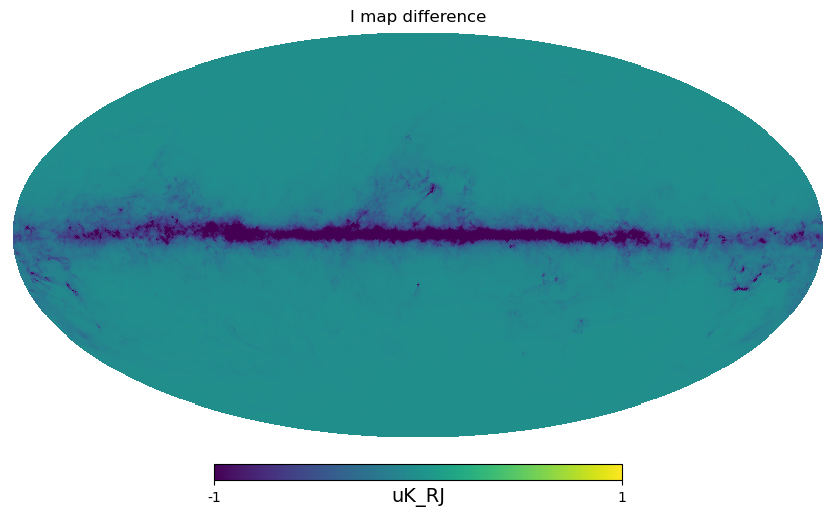

In [7]:
hp.mollview(map_100GHz_delta[0] - map_100GHz_tophat[0], min=-1, max=1, title="I map difference", unit=map_100GHz_tophat.unit)

In [8]:
bandpass_weights = np.array([2,3,5,9,11,11.5,11,9,5,3,2])

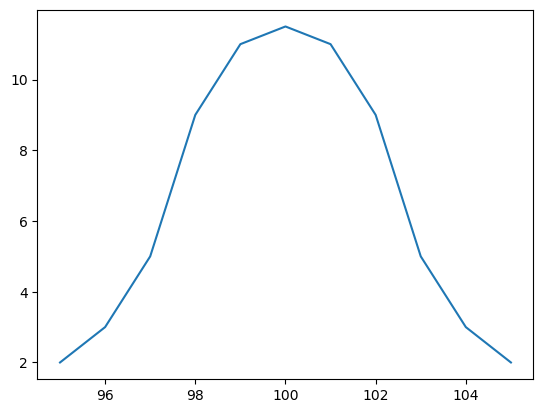

In [9]:
plt.plot(bandpass_frequencies,bandpass_weights);

In [10]:
map_100GHz_bandpass = sky.get_emission(bandpass_frequencies, bandpass_weights)

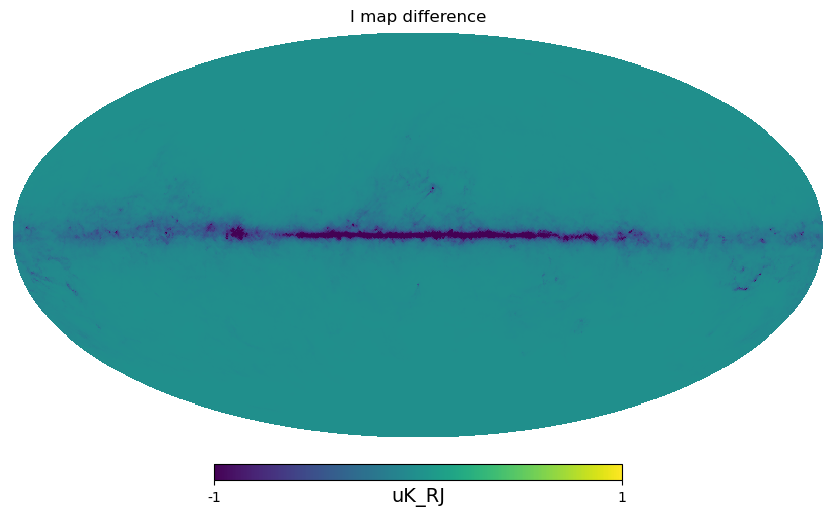

In [11]:
hp.mollview(map_100GHz_bandpass[0] - map_100GHz_tophat[0], min=-1, max=1, title="I map difference", unit=map_100GHz_tophat.unit)